# EDA

An exploratory data analysis will be performed on the different databases created in order to understand the structure of the data

In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### First we will start with the "full_path_info.csv", which has the complete dataset, cointaining the full path, car brand, car model, and car year

In [2]:
# Importing the csv and checking the information content
total_files = pd.read_csv(r'full_path_info.csv', index_col=0)
total_files.head()

,full_path,brand,model,year
0,/data_volume/dataset/images/abarth_124-spider_...,abarth,124-spider,2016
1,/data_volume/dataset/images/abarth_124-spider_...,abarth,124-spider,2016
2,/data_volume/dataset/images/abarth_124-spider_...,abarth,124-spider,2016
3,/data_volume/dataset/images/abarth_124-spider_...,abarth,124-spider,2016
4,/data_volume/dataset/images/abarth_124-spider_...,abarth,124-spider,2016


In [3]:
# Printing total amount of pictures:
print(f'Total amount of pictures: {len(total_files.full_path)}')

Total amount of pictures: 1647627


These pictures contain different types of information that will be categorized in this way in the future: Outside car views (complete and partial), inside car views (complete and partial), trash (images that will not help categorizing anything, like car keys and car documents), and corrupted images that will be ignored.

In [4]:
# Creating a dataframe grouped by brand and model and checking its structure
total_files_df = total_files.groupby(['brand', 'model']).size().reset_index(name='amount')
total_files_df.head()

,brand,model,amount
0,abarth,124-spider,724
1,abarth,500,3085
2,abarth,500c,1448
3,abarth,595,1008
4,abarth,595-competizione,1399


In [5]:
# Checking amount of car brands and car models
brands = len(set(total_files_df['brand']))
models = len(total_files_df['model'])

print(f'There are {brands} car brands and {models} car models')

There are 57 car brands and 837 car models


Since there are many models, especially with number names we will check if there are any repeated model names

In [6]:
# Checking if there are any repeated model names:
model_list_total =[]
for i in range(len(total_files_df)):
  model_list_total.append(total_files_df.model[i])
  
print(f'Repeated model names: {len(model_list_total) - len(set(model_list_total))}')

Repeated model names: 13


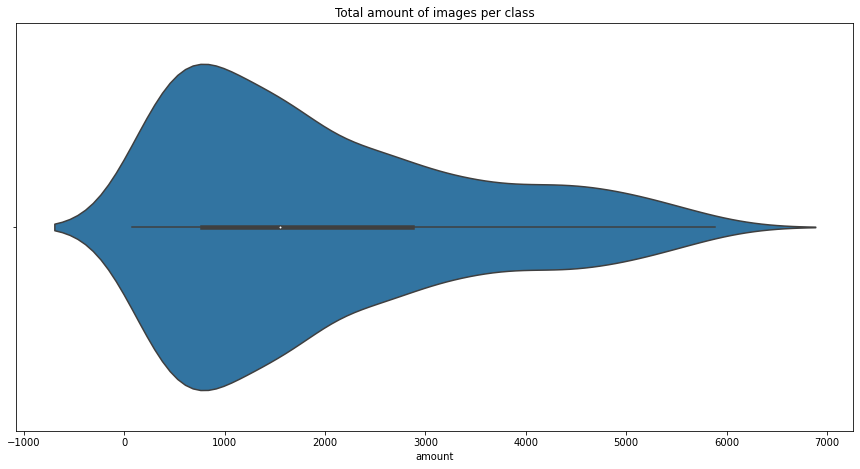

In [7]:
# Plotting the amount of images per class and the interquartile range
plt.figure(figsize=(15, 7.5))
sns.violinplot(x = total_files_df.amount).set(title='Total amount of images per class');

In [8]:
# Minimum and maximum files in a model-brand class
print(f'Minimum files in a model-brand class: {total_files_df["amount"].min()}')
print(f'Maximum files in a model-brand class: {total_files_df["amount"].max()}')

Minimum files in a model-brand class: 74
Maximum files in a model-brand class: 6112


We can see there is a great imbalance of classes that will need to be dealt with to minimize the error at learning and classifying those underrepresented categories.

Since the amount of images is too large and it would require an effort in time and resources that we don't have do to time-to-market and hardware limitations, we will initially reduce the classes considering a maximum of 300 raw images (meaning that it contains all sorts of images) per class at the most if there aren't many classes with less than that amount.

In [9]:
# Number of model-brand classes that have less than 300 pics and its percentage regarding all classes
mask_total_files = total_files_df['amount'] < 300
classes_less_300 = len(total_files_df['amount'][mask_total_files])

classes_less_300_percent = round(classes_less_300 / models * 100, 2)

print(f'There are {classes_less_300} classes with less than 300 images, which represents {classes_less_300_percent}% of the total amount')

There are 61 classes with less than 300 images, which represents 7.29% of the total amount


Since there aren't many classes that will be affected by underrepresentation, we will continue with that approach

#### 300 images has been selected at most and their info has been saved to the file 'pickled_images_selected.csv', which contains the pickle path (these pickles contain the data about the size of the pictures, categories found in it and their respecting bounding boxes, among others), brand, model and original path. We will analyze this dataset next

In [10]:
# Importing the csv and checking the information content
images_selected = pd.read_csv(r'/pickled_images_selected.csv',  index_col=0)
images_selected.head()

,pickle_path,brand,model,original_path
index,,,,
1,/data_volume/dataset/pickled_images/abarth/124...,abarth,124-spider,/data_volume/dataset/sample_dataset_images/aba...
2,/data_volume/dataset/pickled_images/abarth/124...,abarth,124-spider,/data_volume/dataset/sample_dataset_images/aba...
3,/data_volume/dataset/pickled_images/abarth/124...,abarth,124-spider,/data_volume/dataset/sample_dataset_images/aba...
4,/data_volume/dataset/pickled_images/abarth/124...,abarth,124-spider,/data_volume/dataset/sample_dataset_images/aba...
5,/data_volume/dataset/pickled_images/abarth/124...,abarth,124-spider,/data_volume/dataset/sample_dataset_images/aba...


In [11]:
# Creating a dataframe grouped by brand and model and checking its structure
images_selected_df = images_selected.groupby(['brand', 'model']).size().reset_index(name='amount')
images_selected_df.head()

,brand,model,amount
0,abarth,124-spider,300
1,abarth,500,291
2,abarth,500c,292
3,abarth,595,299
4,abarth,595-competizione,294


When we tried to train the model with this new information we found out that the amount of classes didn't match. We will proceed to find what is going on

In [12]:
# Checking amount of car classes, by using the column model:
actual_models = len(images_selected_df['model'])

print(f'Amount of car models: {actual_models}')

Amount of car models: 836


We can see there is one less class. Since there were 13 repeated car model names in the past, we want to discard that it is one of these repeated names. If the number is still 13 it means that none of these repeated model names are missing, and we can use the difference of sets (which will create unique elements, that would not be able to capture the missing class since the repeated name would be eliminated) to calculate which one is not there.

In [13]:
model_list_selected =[]
for i in range(len(images_selected_df)):
  model_list_selected.append(images_selected_df.model[i])
print(f'Repeated model names: {len(model_list_selected) - len(set(model_list_selected))}')

Repeated model names: 13


The repeated model names are the same, so we can proceed with the set substraction to find the missing class

In [14]:
print(f'Class missing in the cleaned dataset: {set(model_list_total) - set(model_list_selected)}')

Class missing in the cleaned dataset: {'one-clubman'}


After checking the one-clubman model we found that all the folders that belonged to it had corrupted files, and they were ignored during the selection process. These are the following folders with 100% of corrupted images:

mini_one-clubman_2010

mini_one-clubman_2011

mini_one-clubman_2017

mini_one-clubman_2018

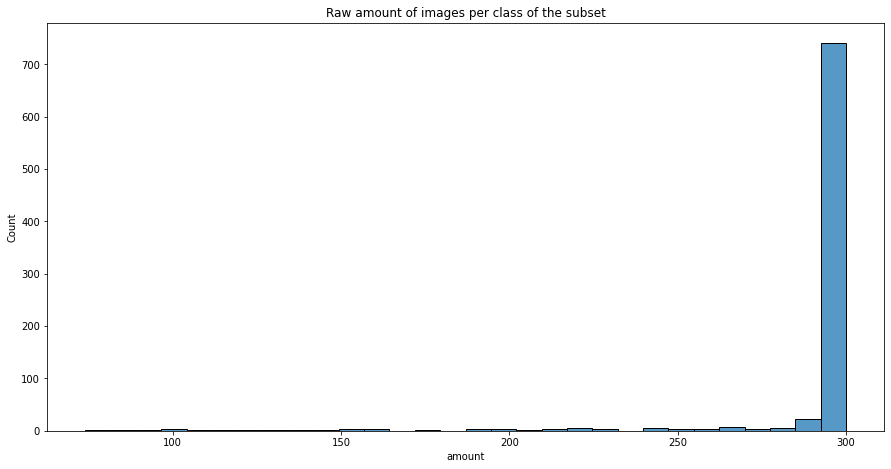

In [15]:
# Plotting the raw amount of images per class after selection
plt.figure(figsize=(15, 7.5))
sns.histplot(x =images_selected_df.amount, bins=30).set(title='Raw amount of images per class of the subset');

In [16]:
# Calculating the average amount of pictures per class
df_mean = round(images_selected_df['amount'].mean(), 2)

print(f'Average amount of pictures per class: {df_mean}')

Average amount of pictures per class: 290.09


In [17]:
# Calculating the number of classes that have less than the average
mask_mean_less = images_selected_df['amount'] < df_mean
models_less_mean = len(images_selected_df['amount'][mask_mean_less])
models_more_mean = actual_models - models_less_mean


print(f'There are {models_less_mean} classes that have less images than the average and {models_more_mean} that have more')
#print(f'Number of classes that have less images than the average: {models_less_mean}')

There are 84 classes that have less images than the average and 752 that have more


In [18]:
# Calculating the number of classes that have less than the average
percentage_classes_less = round((models_less_mean / actual_models) * 100, 2)
print(f'Percentage of classes with less than the average: {percentage_classes_less}%')

Percentage of classes with less than the average: 10.05%


There aren't many classes with less than the average, so we will move on with this initial approach

#### We have created 2 datasets with all the clean car images (outside views) to train and test the DenseNet121 model for brand-model classification, one for train ('train_sample_clasifier.csv') and one for test ('test_sample_clasifier.csv'). We will analyze them now

In [19]:
# Importing the csv and checking the information content
train_pictures = pd.read_csv(r'train_sample_clasifier.csv')
test_pictures = pd.read_csv(r'test_sample_clasifier.csv')

In [20]:
# Checking the amount distribution of the images
total_clean_train_images = len(train_pictures)
total_clean_test_images = len(test_pictures)
total_clean_images = total_clean_train_images + total_clean_test_images

print(f'There are {total_clean_images} images in total, {total_clean_train_images} in train and {total_clean_test_images} in test')

There are 95327 images in total, 76248 in train and 19079 in test


In [21]:
# Checking the percentage distribution of the images
train_percentage = round((total_clean_train_images / total_clean_images)* 100)
test_percentage = abs(train_percentage -100)

print(f'The {train_percentage}% of the images belong to train and {test_percentage}% to test')

The 80% of the images belong to train and 20% to test


In [22]:
# Creating a clean train dataframe
train_clean_df = train_pictures.groupby(['model', 'brand']).size().reset_index(name='amount')
train_clean_df.head()

,model,brand,amount
0,1007,peugeot,113
1,106,peugeot,97
2,107,peugeot,98
3,108,peugeot,92
4,114,bmw,83


In [23]:
# Analyzing the average amount of images per class, the minimum and the maximum in train
train_clean_avg = round(train_clean_df.amount.mean())
train_clean_min = min(train_clean_df.amount)
train_clean_max = max(train_clean_df.amount)

print(f'The average of pictures per class in train is {train_clean_avg}, the minimum amount {train_clean_min}, and the maximum amount {train_clean_max}')

The average of pictures per class in train is 91, the minimum amount 17, and the maximum amount 134


In [24]:
# Creating a clean test dataframe
test_clean_df = test_pictures.groupby(['model', 'brand']).size().reset_index(name='amount')
test_clean_df.head()

,model,brand,amount
0,1007,peugeot,30
1,106,peugeot,32
2,107,peugeot,25
3,108,peugeot,20
4,114,bmw,33


In [25]:
# Analyzing the average amount of images per class, the minimum and the maximum in test
test_clean_avg = round(test_clean_df.amount.mean())
test_clean_min = min(test_clean_df.amount)
test_clean_max = max(test_clean_df.amount)

print(f'The average of pictures per class in test is {test_clean_avg}, the minimum amount {test_clean_min}, and the maximum amount {test_clean_max}')

The average of pictures per class in test is 23, the minimum amount 1, and the maximum amount 41


In [26]:
# Creating a function to bin the amounts of images per class and categorize them to simplify the plotting process
def amount_to_categorical(value):
    if value <= 20:
        return "1 to 20"
    elif value <= 40:
        return "21 to 40"
    elif value <= 60:
        return "41 to 60"
    elif value <= 80:
        return "61 to 80"
    elif value <= 100:
        return "81 to 100"   
    else:
        return "More than 100"

In [27]:
# Applying the amount_to_categorical function to both train and test dataframes and creating a new column with that info
train_clean_df["Amount of Images"] = train_clean_df.amount.apply(amount_to_categorical)
test_clean_df["Amount of Images"] = test_clean_df.amount.apply(amount_to_categorical)

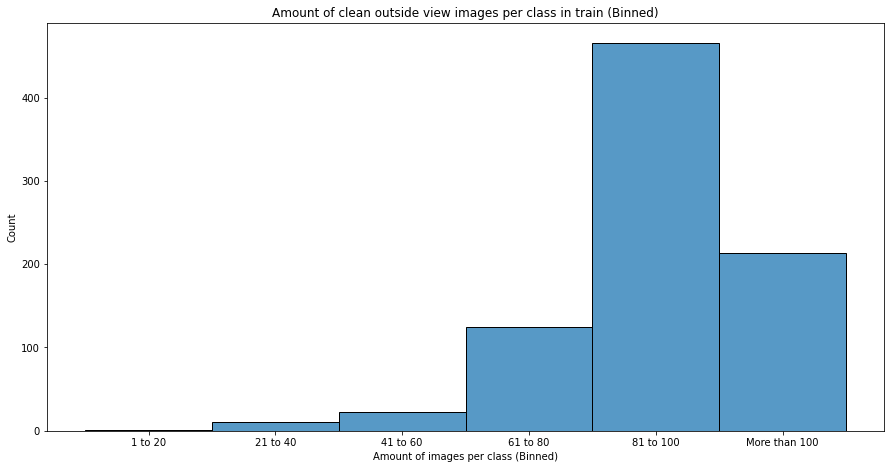

In [28]:
# Plotting the binned amount distribution of clean outside view images per class in train
plt.figure(figsize=(15, 7.5))
sns.histplot(sorted(train_clean_df['Amount of Images'])).set(title = 'Amount of clean outside view images per class in train (Binned)', 
                                                             xlabel = 'Amount of images per class (Binned)');

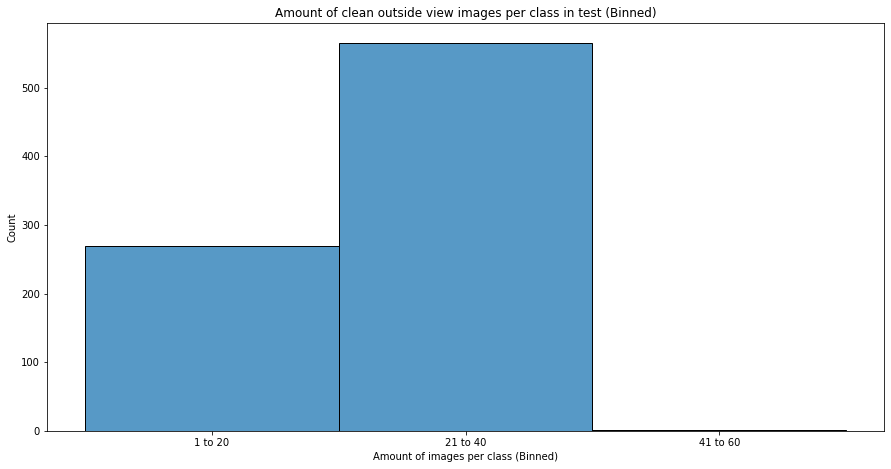

In [29]:
# Plotting the binned amount distribution of clean outside view images per class in test
plt.figure(figsize=(15, 7.5))
sns.histplot(sorted(test_clean_df['Amount of Images'])).set(title = 'Amount of clean outside view images per class in test (Binned)', 
                                                             xlabel = 'Amount of images per class (Binned)');

#### Since it was considered that adding more images would yield better results, we took extra 300 raw images per category to be added to training that were not included last time, and to deal with the class imbalance, copied again the pictures for those categories under 100 clean images until each class reached that amount. This shouldn't be a problem since there are 4 different random data augmentation types being applied to each picture (rotation, flip, brightness and zoom) and they will vary even if some are repeated. We will analyze the dataset that contains the final training images, called 'final_train_images.csv'

In [30]:
# Importing the csv and checking the information content
final_train_pictures = pd.read_csv(r'final_train_images.csv')
final_train_pictures.drop(columns = final_train_pictures.columns[0], axis = 1, inplace= True)
final_train_pictures.head()

,full_path,brand,model
0,/data_volume/dataset/sample_classifier_images/...,abarth,124-spider
1,/data_volume/dataset/sample_classifier_images/...,abarth,124-spider
2,/data_volume/dataset/sample_classifier_images/...,abarth,124-spider
3,/data_volume/dataset/sample_classifier_images/...,abarth,124-spider
4,/data_volume/dataset/sample_classifier_images/...,abarth,124-spider


In [31]:
# Creating a final train dataframe
final_images_train_df = final_train_pictures.groupby(['model', 'brand']).size().reset_index(name='amount')
final_images_train_df.head()

,model,brand,amount
0,1007,peugeot,271
1,106,peugeot,234
2,107,peugeot,216
3,108,peugeot,198
4,114,bmw,180


In [32]:
# Analyzing the average amount of images per class, the minimum and the maximum in train 
train_all_avg = round(final_images_train_df.amount.mean())
train_all_min = min(final_images_train_df.amount)
train_all_max = max(final_images_train_df.amount)

print(f'The average of pictures per class in train is {train_all_avg}, the minimum amount {train_all_min}, and the maximum amount {train_all_max}')

The average of pictures per class in train is 192, the minimum amount 100, and the maximum amount 299


In [33]:
# Creating a new function to bin the amounts of images per class and categorize them to simplify the plotting process in train
def amount_to_categorical_all_train(value):
    if value <= 130:
        return "100 to 130"
    elif value <= 160:
        return "131 to 160"
    elif value <= 190:
        return "161 to 190"
    elif value <= 220:
        return "191 to 220"
    elif value <= 250:
        return "221 to 250"
    elif value <= 280:
        return "251 to 280"  
    else:
        return "More than 280"

In [34]:
# Applying the amount_to_categorical function to the train dataframe and creating a new column with that info
final_images_train_df["Amount of Images"] = final_images_train_df.amount.apply(amount_to_categorical_all_train)

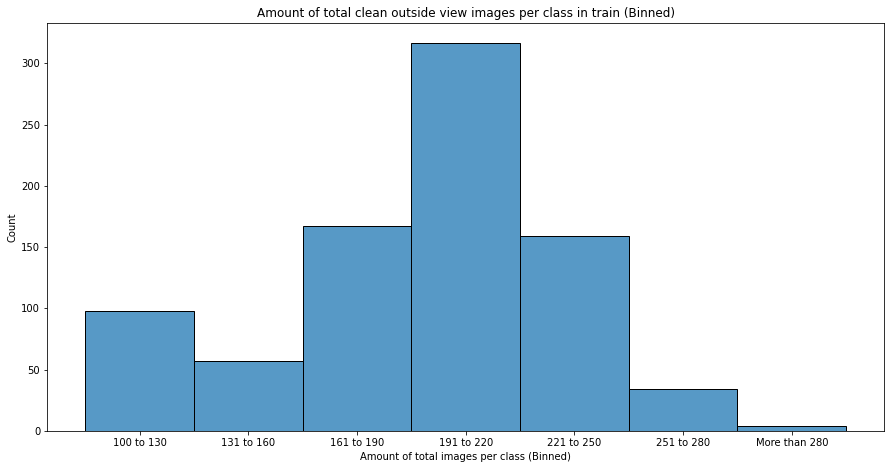

In [35]:
# Plotting the binned amount distribution of clean outside view images per class in train
plt.figure(figsize=(15, 7.5))
sns.histplot(sorted(final_images_train_df['Amount of Images'])).set(title = 'Amount of total clean outside view images per class in train (Binned)', 
                                                             xlabel = 'Amount of total images per class (Binned)');

#### Now we will move to a new model, MobileNetV3, which was used to classify images as car interior and car exterior. The following database consiered also trash, but the Detectron2 model already filtered it, so it was not considered. We will analyze that info contained in the 'mobilenet_balanced.csv' file, that contains images tagged by hand

In [36]:
# Importing the csv and checking the information content
tagged_images = pd.read_csv(r'mobilenet_balanced.csv')
tagged_images.drop(labels= ['Unnamed: 0'], axis = 1, inplace= True)
tagged_images.head()

,path,class
0,/data_volume/dataset/images_for_manual_tagging...,1.0
1,/data_volume/dataset/images_for_manual_tagging...,1.0
2,/data_volume/dataset/images_for_manual_tagging...,1.0
3,/data_volume/dataset/images_for_manual_tagging...,2.0
4,/data_volume/dataset/images_for_manual_tagging...,2.0


In [37]:
# Changing the values from numbers to strings to identify them better
tagged_images['class'].replace([0, 1, 2], ['Car external', 'Car internal', 'Trash'], inplace= True)

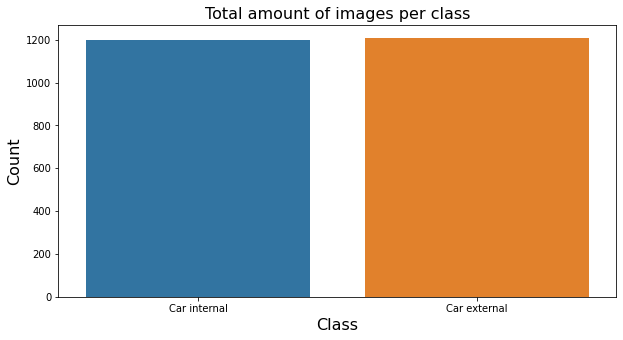

In [38]:
# Plotting the total amount of images per class
tagged_images.drop(tagged_images.index[tagged_images['class'] == 'Trash'], inplace=True)
plt.figure(figsize=(10, 5))
sns.countplot(tagged_images['class'])
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Total amount of images per class', fontsize=16)
plt.show;

In [39]:
# Printing the amount of elements in each class
tagged_images_per_class = tagged_images['class'].value_counts()
tagged_images_per_class

Car external    1208
Car internal    1200
Name: class, dtype: int64

The classes are balanced, and the MobileNet model that was trained with them yielded a very good result in train of 97% accuracy